# 使用合成控制法对比黄河的水资源利用陷阱

大概的步骤：
- 加载数据
- 确定数据中 Predictors 和 Outcome，区分 observation 和控制变量
- 确定探索的时间点
- 将数据转化为 long panel-data
- 加载相关的包，进行试验
- 分析试验结果，找寻替代方案

## 首先利用样例数据测试R包

In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
german = pd.read_stata("../data/repgermany.dta")
german.head()
german.shape

,index,country,year,gdp,infrate,trade,schooling,invest60,invest70,invest80,industry
0,1.0,USA,1960.0,2879,NaN,9.693181,43.799999,NaN,NaN,NaN,NaN
1,1.0,USA,1961.0,2929,1.075182,9.444654,NaN,NaN,NaN,NaN,NaN
2,1.0,USA,1962.0,3103,1.116071,9.429324,NaN,NaN,NaN,NaN,NaN
3,1.0,USA,1963.0,3227,1.214128,9.470706,NaN,NaN,NaN,NaN,NaN
4,1.0,USA,1964.0,3420,1.308615,9.725879,NaN,NaN,NaN,NaN,NaN


(748, 11)

In [27]:
from rpy2 import robjects as ro

r_script = """
rm(list=ls())
library(foreign)
library(Synth)
library(xtable)

# Load Data 
d <- read.dta("../data/repgermany.dta")
## Table 1 & 2, Figure 1, 2, & 3
help(dataprep)

## pick v by cross-validation
# data setup for training model
dataprep.out <-
  dataprep(
           foo = d,
           predictors    = c({predictor}),
           dependent     = {outcome},
           unit.variable = 1,
           time.variable = 3,
           special.predictors = list(
            list("industry", 1971:1980, c("mean")),
            list("schooling",c(1970,1975), c("mean")),
            list("invest70" ,1980, c("mean"))
           ),
           treatment.identifier = 7,
           controls.identifier = unique(d$index)[-7],
           time.predictors.prior = 1971:1980,
           time.optimize.ssr = 1981:1990,
           unit.names.variable = 2,
           time.plot = 1960:2003
         )

# fit training model
synth.out <- 
  synth(
        data.prep.obj=dataprep.out,
        Margin.ipop=.005,Sigf.ipop=7,Bound.ipop=6
        )


actual_data <- dataprep.out$Y1plot
synth_data <- dataprep.out$Y0plot %*% synth.out$solution.w 

out_list <- list(
  y1 = actual_data,
  y0 = synth_data
)
"""

predictors = ["gdp", "trade", "infrate"]
predictor = ""
for i, item in enumerate(predictors):
    if i+1 == len(predictors):
        predictor += '"{}"'.format(item)
    else:
        predictor += '"{}", '.format(item)

outcome = '"gdp"'

synth_result = ro.r(r_script.format(predictor=predictor, outcome=outcome))
synth_result

'"gdp", "trade", "infrate"'

R object with classes: ('list',) mapped to:
<ListVector - Python:0x00000194C05C7EC8 / R:0x00000194B8C4C0C0>
[Matrix, Matrix]
  y1: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x00000194C096BA48 / R:0x00000194B46A3538>
[    2284,     2388,     2527,     2610, ...,    26943,    27449,    28348,    28855]
  y0: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x00000194C041BFC8 / R:0x00000194B5A1A728>
[2117.217550, 2233.966874, 2350.247516, 2466.881015, ..., 29164.159641, 29710.464106, 30842.508766, 31781.397224]

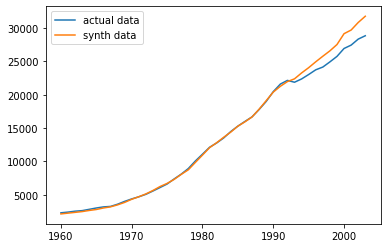

In [29]:
y1 = np.array(list(synth_result[0]))  # 实际数据
y0 = np.array(list(synth_result[1]))  # 生成数据
x = german.year.unique()

plt.plot(x, y1, label="actual data")
plt.plot(x, y0, label="synth data")
plt.legend()
plt.show();

## 使用